In [20]:
import numpy as np
import numpy.random as rand
import math
import matplotlib.pyplot as plt

In [116]:
def motion_update(m, xs):
    return np.array([m + x + rand.normal(0,.1, 3) for x in xs.T]).T

def sensor_update(s, xs):
    return np.array([1-reality[int(x),int(y)] for x, y, _ in xs.T]).T

def sampler(X, p=None, size=0):
    return X[rand.choice(len(X), p=p/p.sum(), size=size)]

def mcl(X_prev, motion, sensor):
    m = motion_update(motion, X_prev)
    s = sensor_update(None, m)
    r = sampler(m.T, p=s, size=1000).T
    print(m.shape, s.shape, r.shape)
    return r

(3, 2000) (2000,) (3, 1000)


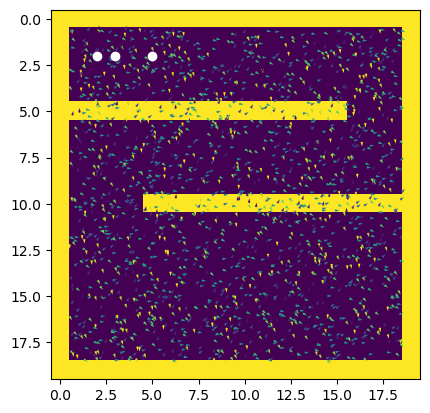

(3, 1000)


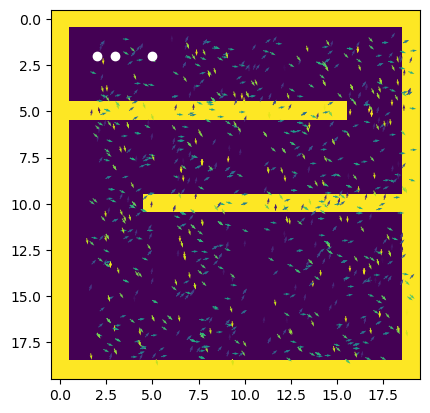

In [117]:
reality = -(np.pad(np.ones((18,18)),1)  - 1)
for ((wx1,wy1),(wx2,wy2)) in [((5,0),(5,15)),((10,5),(10,20))]:
    reality[wx1:wx2+1,wy1:wy2+1] = 1

n = 2000
points = .5+rand.rand(2,n) * 18
angles =  rand.rand(n)*math.pi

init = np.array([*points,angles])
X_1  = mcl(init, (1,0,0), None)
#X_2  = mcl(X_1,  (1,0,0), None)
#X_3  = mcl(X_2,  (2,0,0), None)

def quiver(X):
    plt.quiver(X[0], X[1], np.sin(X[2]), np.cos(X[2]), X[2])

plt.imshow(reality)
quiver(init)
plt.scatter([2,3,5],[2,2,2], c="w")
plt.show()

plt.imshow(reality)
m = motion_update((2,0,0), init)
print(X_1.shape)
quiver(X_1)
plt.scatter([2,3,5],[2,2,2], c="w")
plt.show()

In [4]:
from collections import defaultdict
from functools import partial
import math

def map_cost(point):
    if reality[*point] == 0:
        return 1
    else:
        return math.inf

def l2(a,b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def neighbourhood(p):
    x, y = p
    ps = [(x+1,y+1), (x+1,y  ), (x+1,y-1),
          (x  ,y-1), (x-1,y-1), (x-1,y  ),
          (x-1,y+1), (x  ,y+1)]
    return [p for p in ps if reality[*p] == 0]

def A_star(src, drn, heur):
    opn    = set([src])
    prev   = {}
    g      = defaultdict(lambda: math.inf)
    g[src] = 0
    f      = defaultdict(lambda: math.inf)
    f[src] = heur(src)

    print(opn)
    while opn:
        cur = sorted(opn, key=heur)[0]
        if cur == drn:
            return "found"

        opn.remove(cur)
        for i in neighbourhood(cur):
            score = g[cur] + l2(cur, i)

            if score < g[i]:
                prev[i] = cur
                g[i] = score
                f[i] = score + heur(i)
                opn.add(i)
            
    return opn
    
dst = (15,15)
A_star((0,3), dst, partial(l2, dst))

{(0, 3)}


'found'

In [5]:
robot_real = {
    "position": (2,3),
    "rotation": 0, #degrees
    "sonar_p": (.97, .1),
    "pos_p": (.99, .2),
    "rot_p": (1.04, .2)
}

robot_belief = {
    "position": (2,3),
    "rotation": 0, #degrees
    "sonar_p": (.99, .09),
    "pos_p": (1.02, .22),
    "rot_p": (1.0, .21)
}

In [6]:
import math

def sonar(real, step=.3):
    position = real["position"]
    r = real["rotation"]
    orientation = np.array([math.cos(r), math.sin(r)])

    dist = 0
    while(reality[int(position[0]),int(position[1])] != 1):
        dist += step
        position += orientation * step     
    
    return int(np.random.normal(*real["sonar_p"]) * dist)

sonar(robot_real)

3

In [7]:
import sched, time

class FakeRobot():
    def __init__(self, sched=True):
        self.speed = np.array([0.,0.])
        self.pos   = np.array([0.,0.])
        self.width = 0.5 # meters
        self.rotation = 0 # rads

        self.pos_history   = [np.array([0.,0.])]
        self.speed_history = [np.array([0.,0.])]

        if sched:
            scheduler = sched.scheduler()
            scheduler.enter(.1, 1, self._step, (scheduler,))
            scheduler.run()

    def go_diff(self, l, r):
        self.speed = np.array([l,r])
        self.speed_history += self.speed

    def stop(self):
        self.speed = np.array([0.,0.])
        self.speed_history += self.speed

    def _step(self, step_size=.1):
        scheduler.enter(.1, 1, self._step, (scheduler,))
        l, r  = self.speed
        L     = self.width
        theta = self.rotation

        # Turning radius in meters
        R = L * ((r+l)/(r-l))
        # Turning speed in radians
        w = (r-l) / L

        self.pos += np.array([R*math.sin(w*step_size+theta), R*math.cos(w*step_size+theta)])
        self.rotation += w*step_size
        self.pos_history.append(self.pos.copy())

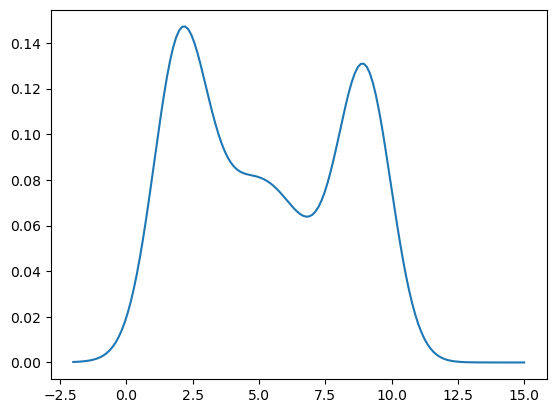

In [31]:
import numpy as np
import numpy.random as rand
from scipy.stats import norm
import matplotlib.pyplot as plt

n = 150

p_pdf = lambda x: .3*norm(2,1).pdf(x) + .4*norm(5,2).pdf(x) + .3*norm(9,1).pdf(x)
p_lut = np.array([p_pdf(x) for x in np.linspace(-2,15,n)])

p = rand.choice(np.arange(n), n, p=p_lut/p_lut.sum())
plt.plot(np.linspace(-2,15,n), p_lut)

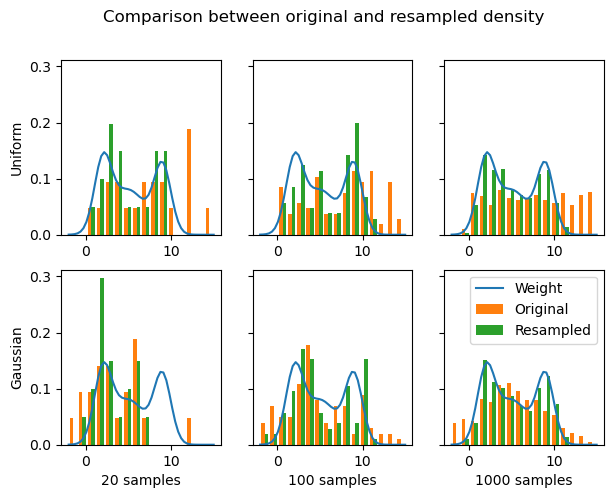

In [163]:
def sampler(X, p=0, size=50):
    samples = []
    r = rand.uniform(0, 1/size)
    c = p[0]
    i = 0
    for m in range(size-1):
        u = r + (m/size)
        while u > c:
            i += 1
            c += p[i-1]
        samples.append(X[i-1])
    return np.array(samples)

#sampler = rand.choice

fig, ax = plt.subplots(2,3, sharey=True, figsize=(7,5))

plt.suptitle("Comparison between original and resampled density")

for n, N in enumerate([20, 100, 1000]):
    q = rand.uniform(0,15,N)
    ax[0,0].set_ylabel("Uniform")
    ax[1, n].set_xlabel(f"{N} samples")
    ax[0, n].plot(np.linspace(-2,15,50), p_lut)
    ax[0, n].hist([q,sampler(q, p=p_pdf(q)/p_pdf(q).sum(), size=N)], bins=np.linspace(-2,15,17), density=True)

for n, N in enumerate([20, 100, 1000]):
    q = rand.normal(5,4,N)
    ax[1,0].set_ylabel("Gaussian")
    ax[1, n].plot(np.linspace(-2,15,50), p_lut)
    a = p_pdf(q)/norm(5,4).pdf(q)
    ax[1, n].hist([q, sampler(q, p=a/a.sum(), size=N)], bins=np.linspace(-2,15,17), density=True)

plt.legend(["Weight", "Original","Resampled"])
plt.savefig("density.pdf")

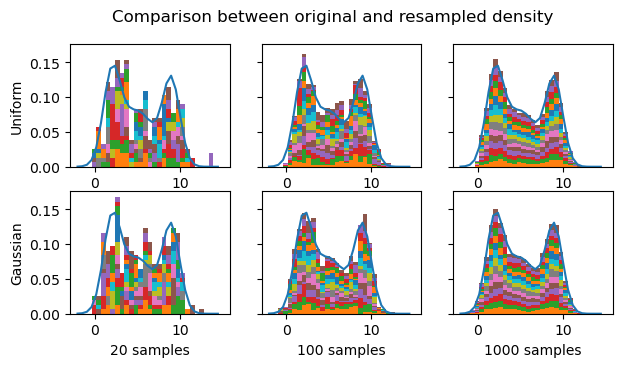

In [170]:
fig, ax = plt.subplots(2,3, sharey=True, figsize=(7,3.5))
bins = np.linspace(-2,15,32)
p_pdf = lambda x: .3*norm(2,1).pdf(x) + .4*norm(5,2).pdf(x) + .3*norm(9,1).pdf(x)
p_lut = np.array([p_pdf(x) for x in bins[:-1]])

plt.suptitle("Comparison between original and resampled density")

unif_err = []
for n, N in enumerate([20, 100, 1000]):
    ax[0,0].set_ylabel("Uniform")
    ax[1, n].set_xlabel(f"{N} samples")
    ax[0, n].plot(bins[:-1], p_lut)
    def new_rand():
        q = rand.uniform(0,15,N)
        s = sampler(q, p=p_pdf(q)/p_pdf(q).sum(), size=N)
        return s
    count, _, _ = ax[0, n].hist([new_rand() for i in range(15)], bins=bins, density=True, stacked=True)
    err = np.abs(count - p_lut)
    norm_err.append((err.mean(), err.var()))

norm_err = []
for n, N in enumerate([20, 100, 1000]):
    ax[1,0].set_ylabel("Gaussian")
    def new_rand():
        q = rand.normal(5,4,N)
        a = p_pdf(q)/norm(5,4).pdf(q)
        s = sampler(q, p=a/a.sum(), size=N)
        return s
    ax[1, n].plot(bins[:-1], p_lut)
    count, _, _ = ax[1, n].hist([new_rand() for i in range(15)], bins=bins, density=True, stacked=True)
    err = np.abs(count - p_lut)
    norm_err.append((err.mean(), err.var()))

plt.savefig("multi.pdf")

In [166]:
p_pdf = lambda x: .3*norm(2,1).pdf(x) + .4*norm(5,2).pdf(x) + .3*norm(9,1).pdf(x)
p_lut = np.array([p_pdf(x) for x in bins[:-1]])
p_lut = (p_lut / p_lut.sum()) * 2

In [167]:
search = np.logspace(1.5,4,20, dtype=np.int64)

unif_err = []
for n, N in enumerate(search):
    def new_rand():
        q = rand.uniform(0,15,N)
        s = sampler(q, p=p_pdf(q)/p_pdf(q).sum(), size=N)
        return s
    hists = [np.histogram(new_rand(), bins, density=True)[0] for i in range(25)]
    errs  = np.array([np.abs(count - p_lut) for count in hists])
    unif_err.append((errs.mean(), errs.var()))

norm_err = []
for n, N in enumerate(search):
    def new_rand():
        q = rand.normal(5,4,N)
        a = p_pdf(q)/norm(5,4).pdf(q)
        s = sampler(q, p=a/a.sum(), size=N)
        return s
    hists = [np.histogram(new_rand(), bins, density=True)[0] for i in range(25)]
    errs  = np.array([np.abs(count - p_lut) for count in hists])
    norm_err.append((errs.mean(), errs.var()))

norm_err, unif_err

([(np.float64(0.052877691075401904), np.float64(0.0033765835943974838)),
  (np.float64(0.04722581360924789), np.float64(0.0026223454580403807)),
  (np.float64(0.03930412662969363), np.float64(0.0019283125498933387)),
  (np.float64(0.035606847142445004), np.float64(0.0015142258048414109)),
  (np.float64(0.031516989887210356), np.float64(0.0012251846645366107)),
  (np.float64(0.025234601646909258), np.float64(0.0008359462132367658)),
  (np.float64(0.02249705478666258), np.float64(0.0006674609479141425)),
  (np.float64(0.02037752937427012), np.float64(0.0004968885044865191)),
  (np.float64(0.01814434130335434), np.float64(0.0003886519452926332)),
  (np.float64(0.01531490950325888), np.float64(0.000292229526582691)),
  (np.float64(0.01320381601139839), np.float64(0.0001919115365481912)),
  (np.float64(0.012280557814621259), np.float64(0.00017151302295135803)),
  (np.float64(0.010858254408751022), np.float64(0.00012699704512385951)),
  (np.float64(0.010079396887639975), np.float64(0.0001162

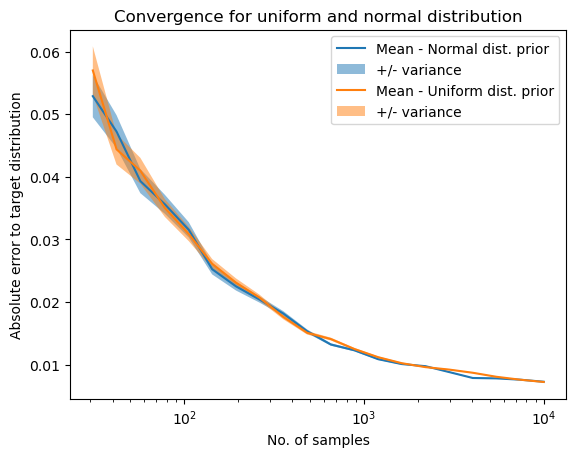

In [169]:
n_mean, n_var = np.array(norm_err).T
u_mean, u_var = np.array(unif_err).T

x = search

plt.plot(x, n_mean)
plt.fill_between(x, n_mean-(n_var), n_mean+n_var, alpha=.5)

plt.plot(x, u_mean)
plt.fill_between(x, u_mean-(u_var), u_mean+u_var, alpha=.5)

plt.xlabel("No. of samples")
plt.ylabel("Absolute error to target distribution")
plt.title("Convergence for uniform and normal distribution")

plt.legend(["Mean - Normal dist. prior","+/- variance",
            "Mean - Uniform dist. prior","+/- variance"])

plt.xscale("log")
plt.savefig("converge.pdf")

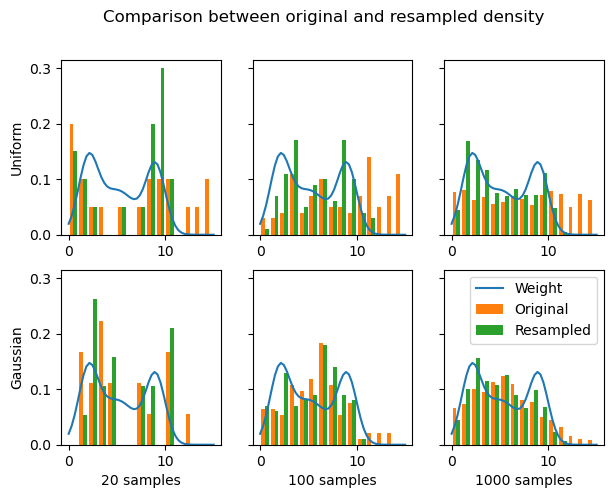

In [105]:
sampler = rand.choice

fig, ax = plt.subplots(2,3, sharey=True, figsize=(7,5))

plt.suptitle("Comparison between original and resampled density")

for n, N in enumerate([20, 100, 1000]):
    q = rand.uniform(0,15,N)
    ax[0,0].set_ylabel("Uniform")
    ax[1, n].set_xlabel(f"{N} samples")
    ax[0, n].plot(np.linspace(0,15,50), p_lut)
    ax[0, n].hist([q,sampler(q, p=p_pdf(q)/p_pdf(q).sum(), size=N)], bins=range(16), density=True)

for n, N in enumerate([20, 100, 1000]):
    q = rand.normal(5,4,N)
    ax[1,0].set_ylabel("Gaussian")
    ax[1, n].plot(np.linspace(0,15,50), p_lut)
    ax[1, n].hist([q, sampler(q, p=p_pdf(q)/p_pdf(q).sum(), size=N)], bins=range(16), density=True)

plt.legend(["Weight", "Original","Resampled"])
plt.savefig("density.pdf")

In [36]:
def linsearch(arr, a, s=0):
    while a > arr[s]:
        s += 1
    return s

def madow(weightArray):
    N = len(weightArray)
    csum = np.cumsum(weightArray)
    startingPoint = np.random.uniform(0, 1/N)
    return np.array([linsearch(csum, startingPoint+(j/N)) for j in range(N)])

madow(p_lut)

array([ 0,  1,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
        8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10])